Divisive suppression explains high-precision firing and contrast adaptation in retinal ganglion cells <br>
url = {https://dx.doi.org/10.7554/elife.19460}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import import_ipynb
try:
    os.chdir('Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from J_broja_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


In [3]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

# k_E and k_S

In [4]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    n = np.sqrt(g)
    g = np.sqrt(g)
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50], z[:len(T):50]

In [5]:
m = 17.015829
n =	1.0
alpha = 27.653582
beta = 0.64906
g = 2174.755419
tau_y = 0.071416

# m = 2.677589
# n =	1.0
# alpha = 11.708909
# beta = 4.693985
# g = 473.653606
# tau_y = 0.024555

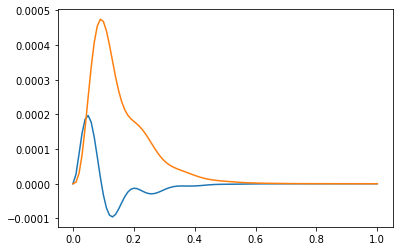

In [6]:
dt = 0.01
TKaxis = np.arange(101)*dt

k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
# y_TK, w_TK = NGD_TK(TKaxis, *[2.67758918, 1.00000000, 1.17089092e+01, 4.69398540, 4.73653606e+02, 2.45547756e-02])
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)

# LPOU input

In [7]:
tot = 1000
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
x = (LPOU-np.mean(LPOU))/np.std(LPOU)

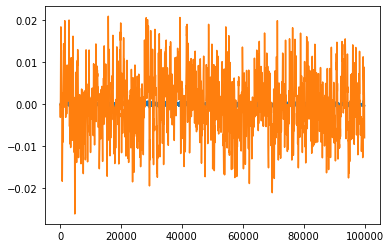

In [8]:
eOutput = np.convolve(x, k_E, 'full')[:len(x)]
sOutput = np.convolve(x, k_S, 'full')[:len(x)]

plt.plot(eOutput)
plt.plot(sOutput)

In [9]:
def f_E(input, boundary):
    if min(input) < -boundary or max(input) > boundary:
        return -1
    return (input+boundary)/(2*boundary)
def f_S(input, boundary):
    if min(input) < -boundary or max(input) > boundary:
        return -1
    p_input = (input+np.abs(input))/2
    p_input = (p_input)/boundary*2
    n_input = (input-np.abs(input))/2
    n_input = (n_input)/boundary*2

    p_output = 1/(1+p_input**1.5)
    n_output = 1/(1+np.abs(n_input)**4)
    return p_output+n_output-1

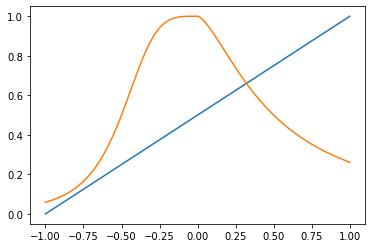

In [10]:
axis = np.linspace(-1,1,1000)
plt.plot(axis, f_E(axis, 1))
plt.plot(axis, f_S(axis, 1))

In [11]:
Output = f_E(eOutput, max(np.abs(eOutput)))*f_S(sOutput, max(np.abs(sOutput)))

(45000.0, 55000.0)

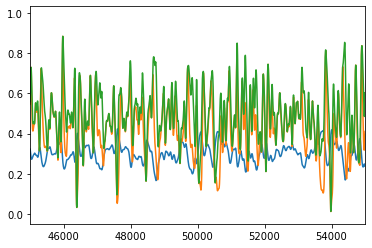

In [12]:
plt.plot(-x*0.05+0.3)
plt.plot(Output)
plt.plot(f_E(eOutput, max(np.abs(eOutput))))
plt.xlim(45000, 55000)

(45000.0, 55000.0)

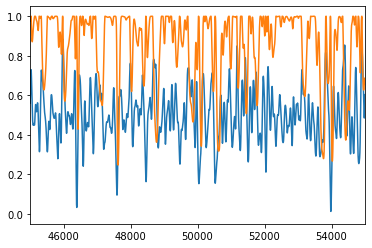

In [13]:
plt.plot(f_E(eOutput, max(np.abs(eOutput))))
plt.plot(f_S(sOutput, max(np.abs(sOutput))))
plt.xlim(45000, 55000)

# MI

In [14]:
window = [-1,1]
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

rstate = SG(eOutput, dt, 0, 10, 10)
timeshift, baseMI = MIfunc(rstate, xstate, dt, window)

rstate = SG(Output, dt, 0, 10, 10)
timeshift, HC_MI = MIfunc(rstate, xstate, dt, window)

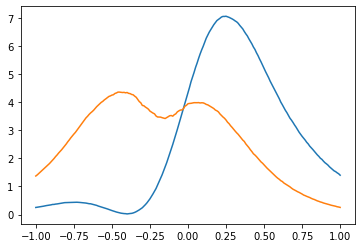

In [15]:
plt.plot(timeshift, baseMI)
plt.plot(timeshift, HC_MI)

# different Contrast

In [16]:
contrast_list = np.arange(0.01, 0.25, 0.03)
dC_Output_list = [f_E(eOutput*contrast, max(np.abs(eOutput)))*f_S(sOutput*contrast, max(np.abs(sOutput))) for contrast in contrast_list]

dC_MI = [0]*len(contrast_list)
for c in range(len(contrast_list)):
    rstate = SG(dC_Output_list[c], dt, 0, 10, 10)
    timeshift, dC_MI[c] = MIfunc(rstate, xstate, dt, window)

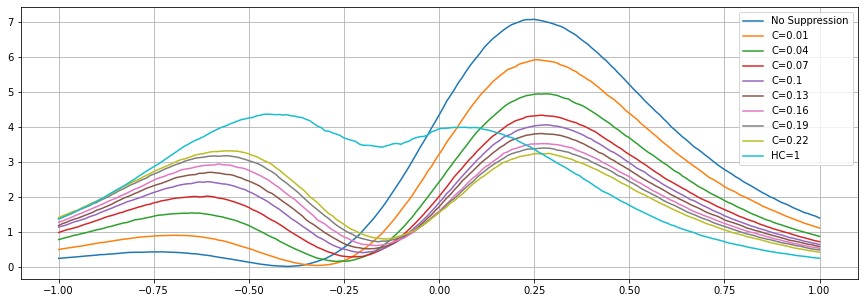

In [17]:
plt.plot(timeshift, baseMI, label='No Suppression')
for c in range(len(contrast_list)):
    plt.plot(timeshift, dC_MI[c], label='C='+str(round(contrast_list[c],3)))

plt.plot(timeshift, HC_MI, label='HC=1')
plt.legend(loc='best')
plt.grid()
plt.gcf().set_size_inches(15,5)

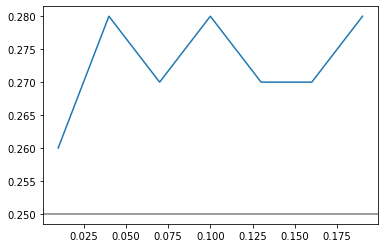

In [19]:
precede = [timeshift[np.argmax(MI)] for MI in dC_MI]

plt.plot(contrast_list[:-1], precede[:-1])
plt.axhline( timeshift[np.argmax(baseMI)], c ='gray' )